# Taconic Parkway, DataFest 2022

Hello, we are team Taconic Parkway from Vassar College. Here is our analysis on the dataset, in 3 parts:

1. Exploratory Analysis
2. Statistical Model
3. Conclusion and Discussion

We hope you enjoy our analysis!

## 1. Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()

Let's first take a look at the target variable, drug resistance, in `S5_scores_cleaned.csv`


In [4]:
df_resist = pd.read_csv("Data/S5_scores_cleaned.csv", dtype={'player_id':str}).dropna()

Note: *A higher mean score indicates that the student has lower efficacy in resisting drugs.*

We can invert `S5_mean` to get a resistance score. A higher resistance score means higher efficacy in resisting drugs. A bit more intuitive.

In [5]:
df_resist['resistance'] = 1 / df_resist['S5_mean']

In [6]:
df_resist.head()

,player_id,weeks,S5_mean,resistance
0,6427001,0,3.900,0.256410
1,6427001,3,3.900,0.256410
2,6427001,6,3.875,0.258065
3,6427027,0,3.800,0.263158
4,6427027,3,4.000,0.250000


Some questions we can ask:
- How many weeks does it take for players to complete this game?
- How do the players' drug resistance change over time?

How many weeks does it take for players to complete this game?

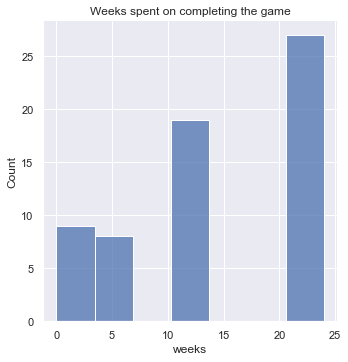

In [7]:
sns.displot(data=df_resist.groupby('player_id').max()['weeks'])
plt.title("Weeks spent on completing the game");

We can see there are 3 groups of players:

- 0-10 weeks
- 10-15 weeks
- 20-25 weeks

How do players' drug resistance change over time for each group?

In [8]:
# 0-5 weeks
player_list_0_5 = df_resist.groupby('player_id').max().query("weeks < 10").index
# 10-15 weeks
player_list_10_15 = df_resist.groupby('player_id').max().query("10 <= weeks < 15").index
# 20-25 weeks
player_list_20_25 = df_resist.groupby('player_id').max().query("20 <= weeks <= 25").index

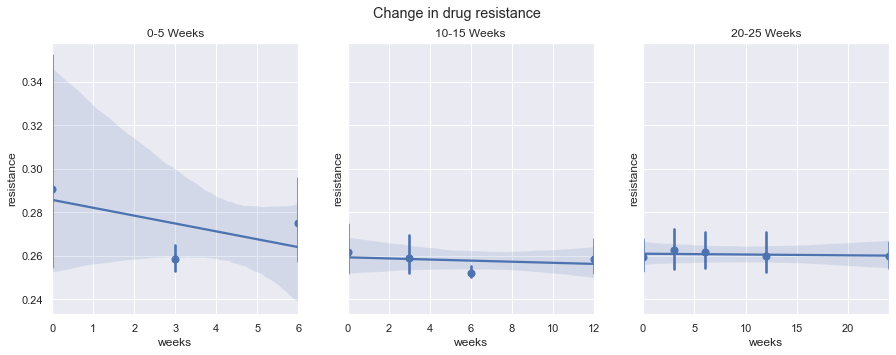

In [9]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

fig.suptitle('Change in drug resistance')
axes[0].set_title('0-5 Weeks')
axes[1].set_title('10-15 Weeks')
axes[2].set_title('20-25 Weeks')

sns.regplot(ax=axes[0], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_0_5)), x_estimator=np.mean)
sns.regplot(ax=axes[1], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_10_15)), x_estimator=np.mean)
sns.regplot(ax=axes[2], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_20_25)), x_estimator=np.mean);

It looks like on average, players who spent the least time completing the game experienced steeper decreases in drug resistance ratings.

***Potential research question: is drug resistance rating associated with playing time in some way?***

Moving on to the main dataset, `logs.csv`

In [10]:
df_log = pd.read_csv("Data/logs.csv", low_memory=False)

This dataset is large, so let's focus on just one player first.

In [11]:
player_a = df_log['player_id'][0]
df_player_a = df_log.query(f"player_id == {player_a}")

This game is divided into 12 scenes ("stacks"). Each with a different theme. See `Spreadsheets\ChallengeStacksData.xlsx` for details on each stack.

In [12]:
# keys are stack ids, values are stack themes
stacks = {
    0: "Cheaters",
    1: "Poolside",
    2: "Kissing",
    3: "Pills",
    4: "Misbehavin'",
    5: "New Year's",
    6: "Serious",
    7: "Racing",
    8: "Scare",
    9: "Prom",
    10: "Confide",
    11: "First Job",
    12: "Tutorial"
}

How long does this player spend on each stack? We can write a function for this:

In [42]:
def stack_play_time(player_id):
    '''
    calculates the amount of time a player spends on each stack
    '''
    df_player = df_log.query(f"player_id == {player_id}")
    play_history = df_player.dropna(subset=['stack_id'])[['stack_id', 'event_time_dbl']].groupby('stack_id').max()
    # need to sort by event_time_dbl because players don't necessarily go through stacks in numerical order
    play_history.sort_values(by='event_time_dbl', inplace=True)
    play_times = play_history.diff()
    play_times.rename(columns={'event_time_dbl': 'play_time'}, inplace=True)
    # we don't care about the tutorial
    play_times.drop(index=12, inplace=True)
    play_times.sort_index(inplace=True)
    play_times['description'] = [stacks[x] for x in play_times.index]
    play_times['player_id'] = player_id
    play_times = play_times[['player_id', 'play_time', 'description']]
    play_times.reset_index(inplace=True)
    play_times['stack_id'] = play_times['stack_id'].astype(int)
    return play_times

In [14]:
stack_play_time(player_a)

,stack_id,player_id,play_time,description
0,0,6427001,3835.0,Cheaters
1,1,6427001,1588.0,Poolside
2,2,6427001,2402.0,Kissing
3,3,6427001,1388.0,Pills
4,4,6427001,1867.0,Misbehavin'
5,5,6427001,3045.0,New Year's
6,6,6427001,2972.0,Serious
7,7,6427001,1925.0,Racing
8,8,6427001,2809.0,Scare
9,9,6427001,1025.0,Prom


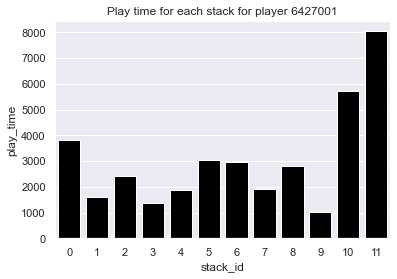

In [15]:
sns.barplot(x='stack_id', y='play_time', data=stack_play_time(player_a), color='black')
plt.title(f"Play time for each stack for player {player_a}");

Now, let's take a look at this metric on an aggregate level.

In [16]:
df_play_time = pd.concat([stack_play_time(player) for player in df_log['player_id'].unique()])

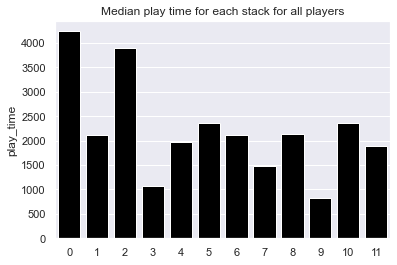

In [17]:
sns.barplot(x=np.arange(12), y='play_time', data=df_play_time.groupby('stack_id').median(), color='black')
plt.title("Median play time for each stack for all players");

We ultimately want to connect play time to drug resistance. So let's dig more into drug-related data.

Some knowledge mini-games have about drugs, in those mini-games, players are prompted to select a fact card they agree with.

We can find fact cards about drugs in `Spreadsheets\KnowledgeMinigameData.xlsx`

In [18]:
df_knowledge = pd.read_excel("Spreadsheets\KnowledgeMinigameData.xlsx", sheet_name='gamedata', header=1, index_col='id')

We are interested in fact cards about drugs. We can look for the keyword "drug" in the descriptions.

In [19]:
for i in range(32): # there are 31 knowledge mini games in total
    if 'drug' in df_knowledge.at[i, 'description']:
        print(f"Factcard ID {i}: {df_knowledge.at[i, 'description']}")

Factcard ID 19: Using drugs not prescribed by a doctor specifically for you can cause serious health problems, even death.
Factcard ID 21: Even using drugs a few times can quickly change to an addiction. 
Factcard ID 22: Using any drug can be more dangerous when taken with alcohol or other drugs.
Factcard ID 26: Teens who drink are more likely to put themselves in situations like unsafe sex and drug use.
Factcard ID 31: Teens who think about their future are less likely to engage in risky behaviors such as doing drugs or drinking alcohol.


We can calculate the time a player spends on drug related mini games.

In [30]:
def drug_mini_levels(player_id):
    drug_fact_cards = ['FactCardData_id:19]', 'FactCardData_id:21]', 'FactCardData_id:22]', 'FactCardData_id:26]', 'FactCardData_id:31]']
    # find out which levels are associated with drugs card by card
    levels = []
    for card in drug_fact_cards:
        df_card = df_log.query(f"player_id=={player_id} & fact_card_id=='{card}'")
        # find out the levels this fact card appears in
        card_levels = df_card['minigame_level'].unique()
        [levels.append(l) for l in card_levels if l not in levels]
    # these are all the drug-related mini game levels for this player
    levels = sorted([int(l) for l in levels])
    return levels

In [514]:
def level_play_time(player_id, level):
    """
    calculates the amount of time a player spends on a certain level of a knowledge mini game
    """
    df_player = df_log.query(f"player_id == {player_id}")
    # event 400 starts mini game 
    # event id 103, 420, 1002, 1003 end mini game
    df_level = df_player.query("event_id == 400 | event_id == 420 | event_id == 1002")
    df_level = df_level.query(f"minigame_level == {level}")
    df_level = pd.concat([df_level, df_player.query("event_id == 103 | event_id == 1003")], axis=0)
    df_level.sort_values(by=['event_time_dbl'], inplace=True)
    df_level.reset_index(drop=True, inplace=True)

    # return df_level
    # sometimes players click away and generate new 400 events, so we need to drop the extra 400 events
    
    # after this loop, we will have alternating rows of 400 and (103/420/1002/1003) events
    first_400_idx = df_level.query("event_id == 400").index[0]
    last_400_idx = df_level.query("event_id == 400").index[-1]
    df_level = df_level.loc[first_400_idx:last_400_idx+1]

    df_level.reset_index(drop=True, inplace=True)
    i = 0
    drop = []
    while i < len(df_level)-1:
        # we want all neighboring (400/non-400) pairs
        curr_id = df_level.at[i, 'event_id']
        next_id = df_level.at[i+1, 'event_id']

        if curr_id == 400 and next_id != 400:
            i += 2 # we want this
        else:
            drop.append(i)
            i += 1

    df_level.drop(index=drop, inplace=True)
    df_level.reset_index(drop=True, inplace=True)

    # after this loop, we will take out edge cases where the player quit halfway
    k = 1
    drop = []
    while k <= len(df_level)-1:
        # we want all neighboring pairs to be on the same day
        curr_date = df_level.at[k, 'date']
        prev_date = df_level.at[k-1, 'date']
        if curr_date != prev_date:
            drop += [k, k-1]
        k += 2
    
    df_level.drop(index=drop, inplace=True)
    df_level.reset_index(drop=True, inplace=True)

    # calculate the play time for each interval
    play_time = 0
    for j in range(1, len(df_level), 2):
        play_start = df_level.at[j-1, 'event_time_dbl']
        play_end = df_level.at[j, 'event_time_dbl']
        # if the player exited in less than a minute, discard this record
        duration = play_end - play_start
        if duration >= 60:
            play_time += duration
    # this is the total amount of time this player spent on this mini game
    return play_time

In [152]:
def drug_mini_play_time(player_id):
    levels = drug_mini_levels(player_id)
    play_time = [level_play_time(player_id, l) for l in levels]
    df_play_time = pd.DataFrame({'player_id':player_id, 'level':levels, 'play_time':play_time})
    return df_play_time

For our player, the play time for all drug-related mini games is:

In [513]:
drug_mini_play_time(player_a)

,player_id,level,play_time
0,6427001,1,447
1,6427001,2,999
2,6427001,3,879
3,6427001,5,1706


## 2. Statistical Model

## 3. Conclusion